In [20]:
# !pip install codecarbon
# !pip install optuna

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW, lr_scheduler
import shutil
import zipfile
# import optuna
import copy
from torch.nn.utils import prune
import io
# from codecarbon import EmissionsTracker

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
try:
    config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=8)
    model = DistilBertForSequenceClassification(config)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
except RuntimeError as e:
    print(f"Failed to load the model: {e}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
except Exception as e:
    print(f"An error occurred: {e}")

In [22]:
model_path = '/content/distilbert_trained.pth'
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=8)
model = DistilBertForSequenceClassification(config)

# Load the pre-trained model weights
model.load_state_dict(torch.load(model_path))

# Assuming 'device' is defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.to(device)

<ipython-input-22-b15e22a86284>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [28]:
def validate_model(model, val_loader, device):
    # Ensure only one tracker instance runs at a time
    tracker = EmissionsTracker(allow_multiple_runs=True)
    tracker.start()

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    all_predictions = []
    all_true_labels = []

    try:
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_loss += outputs.loss.item()
                predictions = torch.argmax(outputs.logits, dim=-1)
                all_predictions.extend(predictions.cpu().numpy())
                all_true_labels.extend(batch['labels'].cpu().numpy())
                correct_val += (predictions == batch['labels']).sum().item()
                total_val += batch['labels'].size(0)
        average_val_loss = val_loss / len(val_loader)
        accuracy = correct_val / total_val

    finally:
        emissions = tracker.stop()
        if emissions:
            total_energy_used = getattr(emissions, 'energy_consumed', 0)
        else:
            total_energy_used = 0  # Default to 0 if emissions data is not available

    return average_val_loss, accuracy, all_predictions, all_true_labels, total_energy_used


In [5]:
df = pd.read_parquet("/content/test-00000-of-00001.parquet")
df['label_int'] = df['label'].str.split("_").str[0].astype('int')

texts = df["quote"].to_list()
labels = df["label_int"].to_list()

In [6]:
num_rows = len(df)
print(num_rows)

1219


In [25]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
MAX_LENGTH = 365

# Dataset and DataLoader preparation
class QuotesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

def encode_data(tokenizer, texts, labels, max_length):
    try:
        if isinstance(texts, pd.Series):
            texts = texts.tolist()
        if isinstance(labels, pd.Series):
            labels = labels.tolist()

        encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        return QuotesDataset(encodings, labels)

    except Exception as e:
        print(f"Error during tokenization: {e}")
        return None

In [26]:
val_dataset = encode_data(tokenizer, texts, labels, MAX_LENGTH)
val_loader = DataLoader(val_dataset, batch_size= 16, shuffle=False)

In [31]:
val_loss, val_accuracy, all_predictions, all_true_labels, emissions = validate_model(model, val_loader, device)
print(val_accuracy)

[codecarbon INFO @ 22:54:12] [setup] RAM Tracking...
[codecarbon INFO @ 22:54:12] [setup] CPU Tracking...
[codecarbon WARNING @ 22:54:12] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 22:54:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 22:54:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 22:54:13] [setup] GPU Tracking...
[codecarbon INFO @ 22:54:13] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:54:13] >>> Tracker's metadata:
[codecarbon INFO @ 22:54:13]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 22:54:13]   Python version: 3.11.11
[codecarbon INFO @ 22:54:13]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 22:54:13]   Available RAM : 12.675 GB
[codecarbon INFO @ 22:54:13]   CPU count: 2
[codeca

0.9794913863822805


In [ ]:
# def prune_model(model, amount):
#     for name, module in model.named_modules():
#         if isinstance(module, torch.nn.Linear):  # Prune linear layers as an example
#             prune.l1_unstructured(module, name='weight', amount=amount)

# # Assuming 'model' is your pre-trained model and 'val_loader' is set up
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# pruning_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
# results = {}

# for level in pruning_levels:
#     prune_model(model, amount=level)
#     val_loss, val_accuracy, all_predictions, all_true_labels = validate_model(model, val_loader, device)
#     print(f"Pruning at {level*100}% leads to an accuracy of {val_accuracy:.2f}%")
#     # Optionally reset the model to its original state if needed


In [32]:
def apply_pruning(model, pruning_params):
    # Iterate over all named parameters in the model
    for name, module in model.named_modules():
        # Apply pruning to specific layers based on the layer's name and the predefined pruning parameters
        if name in pruning_params:
            # Check if the layer is a Linear layer and has a 'weight' attribute to prune
            if hasattr(module, 'weight'):
                prune.l1_unstructured(module, name='weight', amount=pruning_params[name])

def objective(trial):
    # Create a dictionary where each entry corresponds to a specific layer and its suggested pruning rate
    pruning_params = {
        'distilbert.transformer.layer.0.ffn.lin1': trial.suggest_float("lin1_layer0_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.0.ffn.lin2': trial.suggest_float("lin2_layer0_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.1.ffn.lin1': trial.suggest_float("lin1_layer1_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.1.ffn.lin2': trial.suggest_float("lin2_layer1_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.2.ffn.lin1': trial.suggest_float("lin1_layer2_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.2.ffn.lin2': trial.suggest_float("lin2_layer2_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.3.ffn.lin1': trial.suggest_float("lin1_layer3_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.3.ffn.lin2': trial.suggest_float("lin2_layer3_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.4.ffn.lin1': trial.suggest_float("lin1_layer4_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.4.ffn.lin2': trial.suggest_float("lin2_layer4_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.5.ffn.lin1': trial.suggest_float("lin1_layer5_pruning", 0.1, 0.5),
        'distilbert.transformer.layer.5.ffn.lin2': trial.suggest_float("lin2_layer5_pruning", 0.1, 0.5)
    }

    # Load your model
    config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=8)
    model = DistilBertForSequenceClassification(config)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # Apply the pruning as per the trial's suggestion
    apply_pruning(model, pruning_params)

    # Validate the pruned model
    val_loss, val_accuracy, all_predictions, all_true_labels, emissions = validate_model(model, val_loader, device)
    trial.set_user_attr("emissions", emissions)
    trial.set_user_attr("accuracy", val_accuracy)


    return val_accuracy

In [33]:
# Example usage with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


[I 2025-01-29 22:54:38,737] A new study created in memory with name: no-name-403e6edf-7f17-4b56-9528-f091b518bde2
<ipython-input-32-4b55b337298f>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

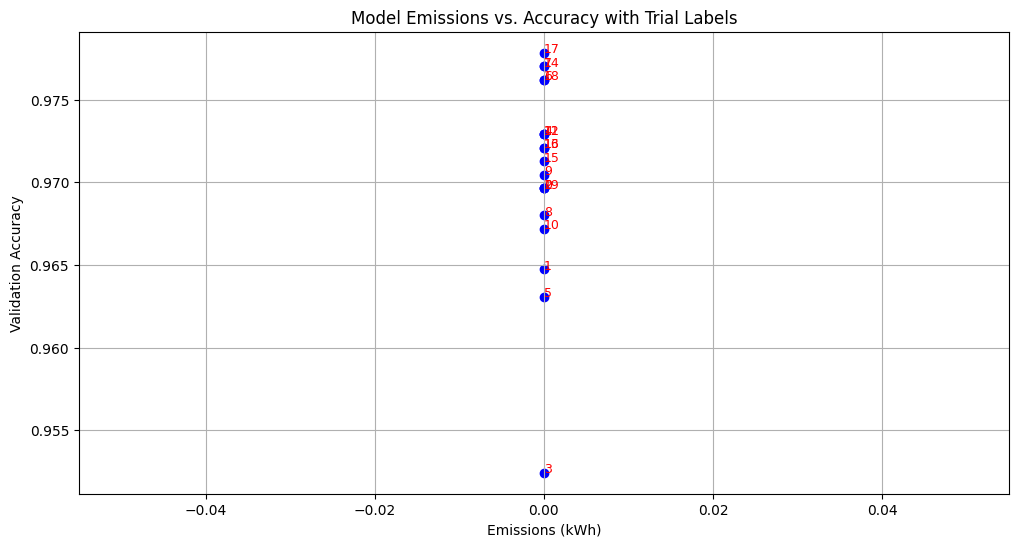

In [34]:
import matplotlib.pyplot as plt

def plot_emissions_vs_accuracy_with_labels(study):
    # Extract emissions and accuracy from each trial
    emissions = [trial.user_attrs["emissions"] for trial in study.trials if "emissions" in trial.user_attrs]
    accuracies = [trial.user_attrs["accuracy"] for trial in study.trials if "accuracy" in trial.user_attrs]
    trial_numbers = [trial.number for trial in study.trials if "emissions" in trial.user_attrs]

    # Create a scatter plot
    plt.figure(figsize=(12, 6))
    for i, (emission, accuracy) in enumerate(zip(emissions, accuracies)):
        plt.scatter(emission, accuracy, color='blue')
        plt.text(emission, accuracy, f'{trial_numbers[i]}', color='red', fontsize=9)

    plt.title('Model Emissions vs. Accuracy with Trial Labels')
    plt.xlabel('Emissions (kWh)')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()

# Assuming 'study' is your Optuna study object
plot_emissions_vs_accuracy_with_labels(study)


In [37]:
import pandas as pd

# Collect data from the study into lists
trial_numbers = [trial.number for trial in study.trials]
accuracies = [trial.value for trial in study.trials]
emissions = [trial.user_attrs['emissions'] for trial in study.trials]

# Create a DataFrame
results_df = pd.DataFrame({
    'Trial Number': trial_numbers,
    'Validation Accuracy': accuracies,
    'Emissions (kWh)': emissions
})

# Display the DataFrame
print(results_df)


    Trial Number  Validation Accuracy  Emissions (kWh)
0              0             0.969647                0
1              1             0.964725                0
2              2             0.969647                0
3              3             0.952420                0
4              4             0.972929                0
5              5             0.963084                0
6              6             0.976210                0
7              7             0.977030                0
8              8             0.968007                0
9              9             0.970468                0
10            10             0.967186                0
11            11             0.972929                0
12            12             0.972929                0
13            13             0.972108                0
14            14             0.977030                0
15            15             0.971288                0
16            16             0.972108                0
17        

In [1]:
sorted_df = results_df.sort_values('Emissions (kWh)', ascending=True)

# Display the sorted DataFrame
print(sorted_df)
This sorted DataFram

SyntaxError: invalid syntax (<ipython-input-1-c4556b490328>, line 5)